<a id='logbook'></a>
# Prediction of roll damping using fully nonlinear potential flow and Ikeda's method

In [1]:
# %load ../../notebooks/imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

#from jupyterthemes import jtplot
#jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import src.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables
import shipflowmotionshelpers.shipflowmotionshelpers as helpers


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


In [69]:
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from rolldecayestimators import fit_on_amplitudes
from reports import mdl_results
import rolldecayestimators.ikeda as ikeda_classes
from pyscores2.indata import Indata
from pyscores2.output import OutputFile
import joblib
import src.visualization.visualize as visualize
from rolldecayestimators import equations_ikeda_naked
from sympy import latex
from rolldecayestimators import logarithmic_decrement
from copy import deepcopy
import src.helpers

## Examples:
from reports import mdl_results
import reports.examples as examples
import reports.examples.ikeda_V_phi_a
import reports.examples.analytical_numerical
import reports.examples.eddy_sigma
import reports.examples.ikeda_section_table
import reports.examples.decision_tree
import reports.examples.KVLCC2_section_table
import reports.examples.logaritimic_decrement
import reports.examples.mdl
from reports.examples.mdl import plot_amplitudes
import reports.examples.ikeda
import reports.examples.hybrid_0
import reports.examples.hybrid_speed

# Abstract

# Nomenclature
| Variable | Explain |
|---|---|
|$\pi$| example |

# Introduction
Many great semi-empirical methods have been developed over the years to analyze various aspects of ship hydrodynamics such as:  resistance,  propulsion  and  seakeeping. These methods were often developed because solving the actual flow was far to complicated and far to time consuming at the time. When computers are now faster and great advancement in field of Computation Fluid Dynamics (CFD) has been achieved, the simpler semi-empirical formulas have now gotten less and less relevant. But have they all of gotten totally irrelevant? 

A semi-empirical method to predict ship roll damping, comonly known as Ikeda's method, will be investigated in this paper, for a use case that can still make it relevant. It will be investigated if this method can be used to increase the accuracy of the roll motion prediction of a nonlinear potential flow method (FNPF), so that this relatively fast option can be used to a larger extent than what is currently possible today. The roll damping of ship is higly depending on vicsous effects which mean that the invicid potential flow lacks a lot of the important physics of the roll motion and can therefore not give relevant results for this degree of freedom, where more advanced options such as: model test or URANS are needed.  

The hybrid method, combining Ikeda's method and FNPF proposed in this paper is investigated using the well known KVLCC2 test case ([Body plan](../../notebooks/11.1_KVLCC2_geometry.ipynb#bodyplan)). 

![Body plan](../figures/KVLCC2_body_plan.png)

This ship was selected partly because it is a well known test case, there were model tests data available from SSPA and also because it does not have any bilge keels. The Ikeda's metod contain methods to predict damping from various component, where the bilge keels is one of them. From the model tests, only the total damping can be observed. Reducing the number of components by having no bilge keels would therefore give more insight into the remaining ones. 

Revisinging these older semi-empirical methods can also help us to understand the hydrodynamics better.

In [3]:
file_paths = [
    '../../data/external/kvlcc2_rolldecay_0kn',
    '../../data/external/kvlcc2_rolldecay_15-5kn',
]
df_parameters = pd.DataFrame()
df_parameters =  helpers.load_parameters(file_path=file_paths)
parameters = df_parameters.iloc[-1]

In [4]:
interesting = [
    'title',
    'LPP',
    'B',
    'ZCG',
    'KXX',
    'S',
    'V',
    'dens',
    'ta',
    'tf',
]
table_parameters = pd.DataFrame(parameters[interesting]).transpose()
table_parameters

,title,LPP,B,ZCG,KXX,S,V,dens,ta,tf
kvlcc2_rolldecay_15-5kn,KVLCC2,4.706,0.853,0.274,0.341,5.981,0.993,1000,0.3059,0.3059


# Methods

## Roll decay test
The initial heel angle during the roll decay tests gives the ship potential energy that is shifting to kinetic energy as the ship starts to move during the inital phase of the roll decay test. The energy is transfered between kinetic energy and potential energy during the oscillations. The ship loses energy over time due to the damping wich can be seen in this [plot](../../notebooks/02.2_ikeda_Be_assumption.ipynb#energy)
![](../figures/energy_transfer.png)

## PIT

A parameters identification technique (PIT) similar to <cite data-cite="7505983/EXYJELCU"></cite> is used to obtain the damping coefficients from the roll decay model test as well as from the FMTP simulated roll decay tests. In this technique, parameters in a mathematical model are determined to get the best fit to a roll decay time signal. A derivation of a matematical model suitable for this study is described below together with a description of how the parameters: damping, stiffness and inertia coefficients where determined.    

The general differential equation for a linearly decaying motion can be written as:

In [5]:
Math(vlatex(equations.diff_eq))

<IPython.core.display.Math object>

Which has an analytical solution <cite data-cite="7505983/KL7A3RIV"></cite>:

In [6]:
Math(vlatex(equations.analytical_solution))

<IPython.core.display.Math object>

Which as in the usual case of having no initial roll velocity ($\phi_0=0$) can be simlified to:

In [7]:
no_initial_speed = sp.simplify(equations.analytical_solution.subs(symbols.phi_0_dot,0))
Math(vlatex(no_initial_speed))

<IPython.core.display.Math object>

And the damping coefficient $\zeta$ is very small for ships so that $\sqrt{1-\zeta}$ is almost 1 and the solution can be further simplified, into something that can easily be recognized as a decaying oscillation:

In [8]:
no_initial_speed_zeta_small = no_initial_speed.subs(
    [(sp.sqrt(1-symbols.zeta**2),1),
     (symbols.zeta*sp.sin(symbols.omega0*symbols.t),0),
    ])
Math(vlatex(no_initial_speed_zeta_small))

<IPython.core.display.Math object>

For a ship the rolling motion during a roll decay can be expressed in general form according to <cite data-cite="7505983/RWXBIIJJ"></cite>:

In [9]:
Math(vlatex(equations.roll_decay_equation_general_himeno))

<IPython.core.display.Math object>

Where $B_{44}(\dot{\phi})$ and $C_{44}(\phi)$ are the damping and stiffness models. A cubic model can be obtained by using cubic damping and stiffness models:

In [10]:
Math(vlatex(equations.b44_cubic_equation))

<IPython.core.display.Math object>

In [11]:
Math(vlatex(equations.restoring_equation_cubic))

<IPython.core.display.Math object>

So that the total equation is written:

In [12]:
Math(vlatex(equations.roll_decay_equation_cubic))

<IPython.core.display.Math object>

This mathematical model can be reduced to a quadratic damping model when $B_3=0$ and a linear model when $B_2=B_3=0$. This equation does not have one unique solution. If all parameters would be  multiplied by a factor $k$ these parameters also be a solution to the equation. All parameters are therefore divided by the total added mass parameters $A_44$ where parameters such as:

In [13]:
equations.normalize_equations[symbols.B_1]

Eq(B_1A, B_1/A_44)

So that the equation with these unique parameters can be written:

In [14]:
Math(vlatex(equations.roll_decay_equation_cubic_A))

<IPython.core.display.Math object>

The parameters of this equation can be identified using least square fit if the time signals $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are all known. This is the case for the results from the FNPF simulations but not from the model tests, where only the roll signal $\phi(t)$ is known. The other time derivatives can be estimated using numerical derivation of a low pass filtered roll signal or Kalman filtered roll signal. The filtering will however introduce some errors in itself. 
Instead of using this "Derivation approach", it has been found that solving the differential equation numerically for guessed parameter values and then using optimization to make really good guesses similarly to what was used by <cite data-cite="7505983/FJHQJJUH"></cite> and <cite data-cite="7505983/9B7QMVJJ"></cite> gives the best parameter estimation. One problem with this "Integration approach" is that in order to converge, the optimization needs a resonable first guess of the parameters. The Derivation approach has therefore been used as a pre-step to obtain a very good first guess of the parameters that can be passed on to the Integration approach. This has been used for both signals from FNPF and model tests where in the latter case numerical derivation is used.

The differential equation is numerically solved as an intial value problem, where the initial states for $\phi(t)$, $\dot{\phi}(t)$ and $\ddot{\phi}(t)$ are used to estimate the following states, by conducting very small time steps using the follownig expression for the acceleration: 

In [15]:
eq_phi1d = sp.Eq(symbols.phi_dot_dot,
      sp.solve(equations.roll_decay_equation_cubic_A,symbols.phi_dot_dot)[0])

accelaration_lambda = lambdify(sp.solve(eq_phi1d,symbols.phi_dot_dot)[0])

Math(vlatex(eq_phi1d))

<IPython.core.display.Math object>

This numerical solution can be compared with the analytical solution above for a linear model. For this case the relation between $\zeta$ and $B_1$ can be expressed as: 

In [16]:
equations.B_1_zeta_eq

Eq(B_1, 2*A_44*omega0*zeta)

and the natural frequency can be obtained from:

In [17]:
A_44_eq = sp.Eq(symbols.A_44, equations.A44)

eqs = [
    A_44_eq,
    equations.C_equation_linear,

]
omega0_eq = sp.Eq(symbols.omega0,sp.solve(eqs, symbols.omega0, symbols.GM)[1][0])
omega0_eq = omega0_eq.subs(symbols.C,symbols.C_1)
omega0_lambda = lambdify(sp.solve(omega0_eq, symbols.omega0)[0])
omega0_eq

Eq(omega0, sqrt(C_1/A_44))

The analytical and numerical solutions are vary similar according to the example: $A_{44} = 1.0$, $B_1 = 0.3$, $C_1 = 5.0$ shown in the figure below.

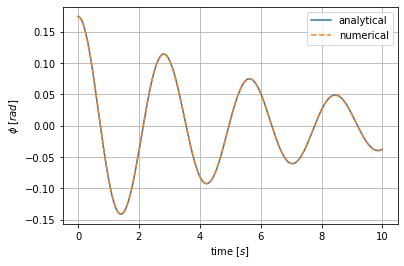

In [18]:
examples.analytical_numerical.show(omega0_lambda, accelaration_lambda)

## Implementation of Ikeda's method
Ikeda's method divides roll damping into five damping components: the friction component $B_F$, the eddy component $B_E$, the lift component $B_L$, the wave component $B_W$ and the bilge keel component $B_{BK}$, as in the following, 

\begin{equation}
B_{44} = B_F + B_E + B_L + B_W + B_{BK}
\end{equation}

Due to the absence of bilge keels for the KVLCC2 the $B_{BK}$ does not need to be included. This means that remaining components will get all the attention in this paper. Ikeda has in a series of papers proposed semi empirical formulas for the viscous damping components: $B_F$, $B_E$ and $B_L$ which have been implemented for this study. The wave damping $B_W$ is calculated using a potential flow strip theory code or a more advance potential flow code such as the FNPF method described as the Hybrid method in this paper.      

Ikeda produced many papers about various aspects of roll damping where most of them are translations from original manuscripts in Japanese. Summaries of this method <cite data-cite="7505983/RWXBIIJJ"></cite>, <cite data-cite="7505983/KAKIM2E2"></cite> and <cite data-cite="7505983/UGK6YEVD"></cite> has been used together with the original papers to understand how the method should be implemented. Falzarano says that the Himeno report and associated computer programs are well-known to have numerous typographical errors. When looking at these resources it becomes evident that there is some variety on how the method should be implemented, regardless if this is due to typographical errors or being variations of the actual method. The implementation was therefore a fairly time consuming task where various alternative implementations needed to be compared and investigated. 

The scale effects of roll damping is considered to mainly be associated with the sking friction component <cite data-cite="7505983/RWXBIIJJ"></cite>. This component makes a very small part of the total damping for the full scale ship, but a substantial part for the model scale ship used in this study. This is the only component in ikedas method that needs to be recalculated when the scale changes.  

For the skin friction damping $B_F$ implementation was made according to the description in <cite data-cite="7505983/UGK6YEVD"></cite>. With the difference that the actual wetted surface $S$ was used instead of the proposed estimation formula. 

The hull lift damping $B_L$ is calculated according to <cite data-cite="7505983/ZVF3F5V5"></cite> and implemented as described in <cite data-cite="7505983/RC2WJ4RI"></cite>. Journe added a linear interpolation to the values for $\kappa$ that were suggested by Ikeda.

A schematic graph of how the parameters vary with speed and roll angle amplitude $\phi_a$ in the current model scale is created with the current implementation of Ikeda as shown below. The roll amplitude is first varied at zero speed (left), the speed is then varied from zero to the froude number corresponding to 15.5 knots in full scale for the KVLCC2 with a roll angle amplitude of 10 degrees (middle). The amplitude is then gradually reduced at the highest froude number down to zero (right). 

Assumming that the trends are correct in Ikeda's method it can be noted from the amplitude variations at zero knots (left):
* $B_W$ does not change with amplitude, implying that they only contribute to the linear part ($B_1$) of the damping. (The $B_W$ was calculated with strip theory here)
* $B_F$ has a small amplitude dependancy but the linear part is dominating.
* $B_E$ has a large amplitude depandancy and only contributes to the quadratic damping ($B_2$)<cite data-cite="7505983/4AFVVGNT"></cite>.

Looking at the speed variation (middle):
* At low speed $B_F$ and $B_E$ are the dominating components. (Note that this ship does not have bilge keels, as that would otherwise also be a large component).
* At high speed the $B_E$ has almost disappeared and is replaced by the $B_L$ which is now the dominating component.
* $B_F$ has a large contribution for all speeds (at model scale).

Looking at the roll amplitude variation (right):
* (Please note that this x-axis is revered in this graph)
* $B_L$ does not change with amplitude, implying that they only contribute to the linear part ($B_1$) of the damping.
* $B_F$ has a small amplitude dependancy but the linear part is dominating.

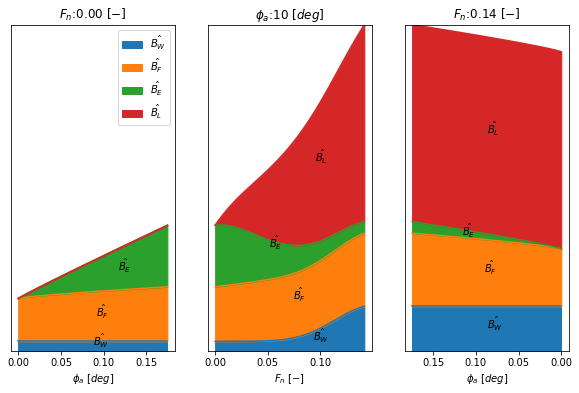

In [19]:
examples.ikeda_V_phi_a.show()

When the damping predicted with Ikeda was compared with corresponding model test it was found that the results were in poor agreement for the zero speed case but quite good results at speed. This was pointing towards the eddy damping being incorrect in the current implementation of Ikeda's method. A thurough investigation of the eddy damping prediction was therefore conducted which is described in the next section.

### Eddy damping
The eddy damping is due to eddies generated around the ship hull during the roll motion. Strong eddies occures at sharp edges in the geometry. Below is an illustration of how the eddy damping changes with bilge radius to beam ratio as predicted with the current implementation of the method. It seems that the damping approaches zero very fast as the bilge radius increase. So having just a small rounding of the bilge, compared to a square section, will have a great impact on the eddy roll damping.  

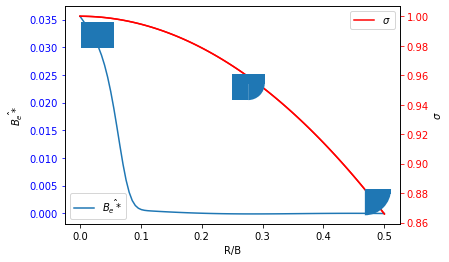

In [20]:
examples.eddy_sigma.show()

Ikeda made experiements on a number of two-dimensional cylinders with various sections <cite data-cite="7505983/4AFVVGNT"></cite>. Ikeda found that the eddy damping per unit length of these sections can be expressed as:

In [21]:
equations_ikeda_naked.eq_B_E0s

Eq(B'_E0, 4*C_r*T_s**4*omega*phi_a*rho/(3*pi))

The total eddy damping can be obtained as an integral over the sections along the ship hull:

In [22]:
equations_ikeda_naked.eq_B_E0

Eq(B_E0, Integral(B'_E0, (x, AP, FP)))

It can be seen from the section damping equation above that the eddy damping increases linearly with both roll amplitude and frequency, and that it will go to zero for small amplitudes and frequencies, which means that it is only included in the quadratic damping term ($B_2$). Ikeda expressed the $C_r$ coefficient to be entirely depending on the hull form.
Ikeda developed a regression formula for $C_r$ based on his experiments, which is used in the prediction method. The authors of this paper have tried to implement this method according to the description in the original paper <cite data-cite="7505983/4AFVVGNT"></cite> but have failed to reproduce the results from Ikeda's experiments exactly. Other resources such as <cite data-cite="7505983/RWXBIIJJ"></cite> and <cite data-cite="7505983/KAKIM2E2"></cite> have also been used without success.

Instead a new regression for $C_r$ was made on the experimental results from <cite data-cite="7505983/4AFVVGNT"></cite>. The experiemntal results were first collected by manual digitalization as seen below:  

In [23]:
examples.ikeda_section_table.show()

,model,$\hat{\omega}$,$\phi_a$,$\hat{B_E}^*$,B_W+B_F,$L_{pp}$,$beam$,$T_s$,$\sigma$,$R_b$,$a_1$,$a_3$,$C_r$
0,A,0.751,0.23,0.037534,0.003636,0.8,0.280,0.112,1.000,0.000000,0.095721,-0.138514,6.791066
1,A,0.507,0.24,0.028413,0.001391,0.8,0.280,0.112,1.000,0.000000,0.095721,-0.138514,7.297515
2,B,0.751,0.30,0.020700,0.003265,0.8,0.280,0.112,0.997,0.010000,0.095950,-0.136454,2.862276
3,B,0.536,0.30,0.013328,0.001111,0.8,0.280,0.112,0.997,0.010000,0.095950,-0.136454,2.582057
4,C,0.751,0.27,0.006151,0.002115,0.8,0.280,0.112,0.995,0.020000,0.096102,-0.135084,0.942686
5,C,0.625,0.21,0.003987,0.001500,0.8,0.280,0.112,0.995,0.020000,0.096102,-0.135084,0.943989
6,D,0.939,0.31,0.007466,0.002039,0.8,0.280,0.112,0.988,0.030000,0.096632,-0.130314,0.790684
7,D,0.751,0.31,0.006145,0.001500,0.8,0.280,0.112,0.988,0.030000,0.096632,-0.130314,0.813690
8,G,0.814,0.24,0.011505,0.088356,0.8,0.185,0.192,0.799,0.182397,-0.347078,-0.007600,0.086061
9,H,0.560,0.30,0.000640,0.001400,0.8,0.398,0.193,0.893,0.195702,0.014252,-0.068862,0.059677


Where $OG/d=0$ for all sections.For the Series60 sections (G-K) the bilge radius $R_b$ was estimated using the following estimation:

In [24]:
equations_ikeda_naked.eq_R_b

Eq(R_b, sqrt(B_s*T_s*(1 - sigma))/sqrt(1 - pi/4))

The nondimensional damping is expressed in <cite data-cite="7505983/4AFVVGNT"></cite> using a star (*) sign. The reason seams to be that Ikeda wants to signal that this damping only has the quadratic part of the damping. This stared damping are defined as:

In [25]:
equations_ikeda_naked.eq_B_E_star_hat

Eq(B_E0_HAT, 8*B_E_star_hat/(3*pi))

$\hat{B_E}^*$ and $(B_W+B_F)^*$ are the experimental values taken from <cite data-cite="7505983/4AFVVGNT"></cite>. Which add up to the total damping:

$\hat{B^*} = \hat{B^*_E} + (B_W+B_F)^*$

The Lewis section coefficients were calculated as:

In [26]:
equations_ikeda_naked.eq_D_1

Eq(D_1, 4*sigma/pi + (H_0 - 1)**2*(-4*sigma/pi + 1)/(H_0 + 1)**2 + 3)

In [27]:
equations_ikeda_naked.eq_a_3

Eq(a_3, (-D_1 + sqrt(9 - 2*D_1) + 3)/D_1)

In [28]:
equations_ikeda_naked.eq_a_1

Eq(a_1, (H_0 - 1)*(a_3 + 1)/(H_0 + 1))

In [29]:
equations_ikeda_naked.eq_B_E_star_hat

Eq(B_E0_HAT, 8*B_E_star_hat/(3*pi))

And the $C_r$ was calculated from the experiments as:

In [30]:
equations_ikeda_naked.eq_C_r_2

Eq(C_r, 3*pi*B_E0_HAT*B_s*T_s*beam**2*sigma/(4*T**4*omega_hat*phi_a))

Instead of trying to invent some very advanced mathematical expression for the $C_r$ regression a simple decision tree model was instead fitted to the $C_r$ data from Ikeda's experiments. The fitted decision tree is illustrated in the figure below:

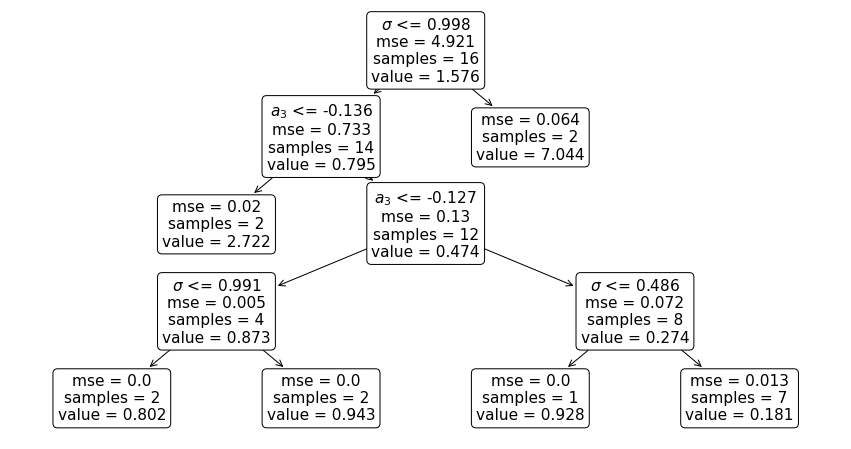

In [31]:
examples.decision_tree.show()

Eventhoug this tree is so simple it has very good accuracy in reproducing the results from Ikedas experiments ($r^2=0.996)$. The $C_r$ was predicted with Ikeda and the alternative decision tree model for the KVLCC2 with section data according to the table below. A comparison is shown in the figure below, where it can be seen that the current Ikeda implementation predicts much higher $C_r$ between station 8 and 14 where the bilge radius is very small.

In [32]:
examples.KVLCC2_section_table.show()

,$x$,$beam$,$T_s$,$\sigma$,$\frac{OG}{d}$,$R_b$,$a_1$,$a_3$
no,,,,,,,,
0,-0.080809,0.171156,0.029412,0.593999,1.100000,0.097589,0.534095,0.093461
1,0.149411,0.410199,0.268382,0.243296,0.120548,0.623047,-0.182446,0.365057
2,0.412519,0.615063,0.305882,0.492228,0.105769,0.667198,0.003204,0.191589
3,0.642738,0.739449,0.305882,0.653719,0.105769,0.604128,0.102394,0.083578
4,0.905847,0.825871,0.305882,0.785794,0.105769,0.502149,0.148893,-0.000246
5,1.136066,0.851037,0.305882,0.878006,0.105769,0.384684,0.154150,-0.057593
6,1.366286,0.852941,0.305882,0.944549,0.105769,0.259643,0.148226,-0.099798
7,1.629394,0.852941,0.305882,0.983797,0.105769,0.140352,0.144000,-0.125462
8,1.859614,0.852941,0.305882,0.997362,0.105769,0.056634,0.142507,-0.134532


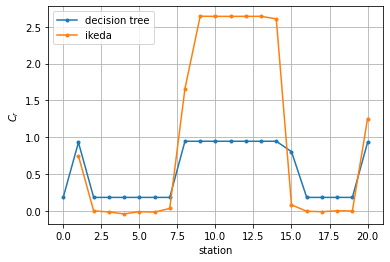

In [33]:
examples.decision_tree.show_KVLCC2_C_r_prediction()

The two alternative ways to calculate the eddy damping will be further discussed below, when comparing the total predicted damping with corresponding results from the model tests.

### Time and frequency domain
Ikeda's method is defined in the frequency domain, where the damping is expressed as a function of roll angle amplitude $\phi_a$ and roll angle frequency $\omega$. The equivalent linear damping $B_e$ (not to confuse with eddy damping $B_E$) is a way to convert the frequency domain damping into time domain damping <cite data-cite="7505983/RWXBIIJJ"></cite>, so that time domain roll simulations can be conducted. The most general way to determine $B_e$ is to assume that the energy loss due to damping during a half cycle of roll is the same when nonlinear and linear dampings are used <cite data-cite="7505983/RYUBZITQ"></cite>. The $B_e$ can then be calculated as a Fourier series expansion of the damping model, which in the case of a cubic model yields as: 

In [34]:
equations.B_e_equation_cubic

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi) + 0.75*B_3*omega0**2*phi_a**2)

And in the case of a quadratic model $B_3=0$ and for the linear model $B_1$ and $B_e$ are the same thing.

So the expression above gives a relation between the frequency domain quantities $\phi_a$, $\omega$ and the time domain quantities $B_1$, $B_2$ and $B_3$ which can be used to obtain the latter ones from the Ikeda's method. This can be done by calculating the damping with Ikeda's method for a variation of frequencies and amplitudes and then fit the above expression to this damping and obtain $B_1$, $B_2$ and $B_3$:

$$B^{Ikeda}(\phi_a, \omega) = B_e(\phi_a, \omega)$$

And in the case of roll decay test $\phi_a$ is the only parameter being varied. In order to investigate this approach an alternative method using the logaritmic decrement <cite data-cite="7505983/BYNJ8CFG"></cite> to obtaining the frequency domain quantities from time series result is used.  

This method is investigated on simulation results with a quadratic model: $B_1 = 0.05$, $B_2 = 0.9$, $A_{44} = 1.0$, $C_1 = 5.0$. The peak values, being the only known amplitudes from this signal, is shown in the figure below.

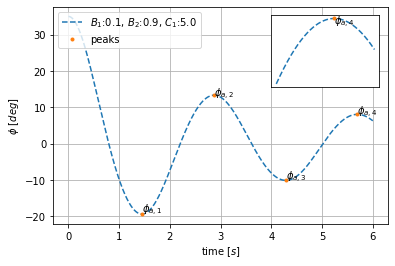

In [35]:
examples.logaritimic_decrement.show_figure_1()

The decrement is calculated as the ratio between every other peak, so that negative and positive roll peaks are separated. 
$$ \Delta_n = \frac{\phi_{a,n}}{\phi_{a,n+2}}$$

The nondimensional $\zeta$ damping coefficient can be calculated from the logaritimic decrement:

$$\zeta = \frac{\delta}{2\pi}=\frac{ln(\Delta)}{2\pi}$$

From where the dimensional damping (Nm*s) can be obtained:

In [36]:
equations.B_1_zeta_eq.subs(symbols.B_1, symbols.B)

Eq(B, 2*A_44*omega0*zeta)

It is not obvious which of the roll amplitudes these dampings correspond to. Four different choices were tried, associating damping $B_n$ with the following amplitudes:
* A : $\phi_n$
* B : $\phi_{n+1}$
* C : $\phi_{n+2}$
* D : $(\phi_n + \phi_{n+1} + \phi_{n+2})/3$

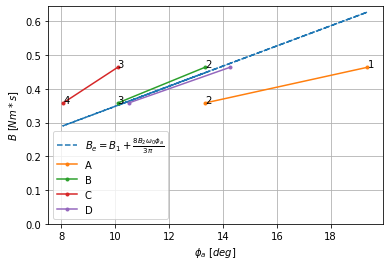

In [37]:
examples.logaritimic_decrement.show_figure_2()

Taking the mean value of peak n and the following two peaks (alt.D) seem to be the approach that best matches the $B_e$ (predicted using the linearized equivalent damping method). The  linearized equivalent damping method therefore seems to be the best way to convert $B_1$, $B_2$, $B_3$ to frequency domain, considering the difficulties with the logaritmic decrement method as described above. The only time this method has been used in this paper, is when damping at individual peaks from a time signal should be converted to frequency domain. 

## FNPF

## Hybrid method
A Hybrid method has been developed where wave damping $B_W$ obtained with FNPF as described in the previous section is used together with the visous damping contributions from Ikeda's method. The wave damping was determined by using the PIT described above on results from FNPF simulations of roll decay tests. 

# Results

## Roll decay model tests
### 0 knots
Data from two roll decay model tests conducted at zero speed were available: [Roll decay model tests 0 knots](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#rolldecay). These tests where analyzed by fitting a [Cubic model](../../notebooks/01.2_select_suitable_MDL_test_KLVCC2.ipynb#cubic_model) to the model test data. The two models were very similar in terms of roll damping and stiffness, suggesting good repeatability in the model tests as well as in the parameter identification technique (PIT) used. The individual damping from each oscillation obtained with the logarithmic decrement method are very scattered, but this does not seem to influence the two models for the 0 speed case, which are very similiar.  

### 15.5 knots
Data from one roll decay model tests conducted at a ship speed corresponding to 15.5 knots full scale ship speed was also available. This model tests was analyzed in the same way as the other tests at zero knots. It was found that the damping was higher at speed. The ship got a small [yaw rate](../../notebooks/01.3_select_suitable_MDL_test_KLVCC2_speed.ipynb#yawrate) at the end of test, giving a small steady roll angle due to the centrifugal force. Since this effect is not included in the matematical model used, the steady roll angle was instead removed by removing the linear trend in the roll angle signal. 

The coefficients obtained from model test are summarized in model scale units in the table below:

In [38]:
models = examples.mdl.get_models()
df_results = examples.mdl.gather_results(models)

In [39]:
amplitudes = examples.mdl.analyze_amplitudes(models=models)

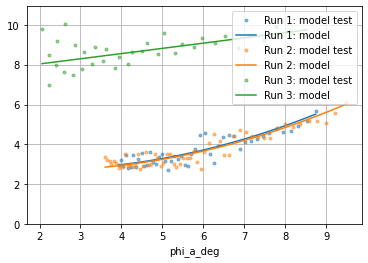

In [41]:
## Plotting:
fig,ax=plt.subplots()
for id,row in df_results.iterrows(): 
    df_amplitudes = amplitudes[id].copy()
    plot_amplitudes(df_amplitudes=df_amplitudes, paper_name = row.paper_name, ax=ax)
    
y_lim_motions = list(ax.get_ylim())
y_lim_motions[0]=0
y_lim_motions[1]*=1.05
ax.set_ylim(y_lim_motions)
ax.grid(True)

In [42]:
models_mdl = examples.mdl.get_models()
df_results = examples.mdl.gather_results(models_mdl)
df_results = pd.merge(left=df_results, right=mdl_results.df_rolldecays, how='inner', 
         left_index=True, right_index=True, suffixes=('','_db'))

df_results['V'] = df_results['ship_speed']*1.852/3.6
df_results['fn'] = df_results['V']/np.sqrt(df_results['g']*df_results['lpp'])

interesting = ['paper_name','fn','omega0','B_1','B_2','B_3']
df_table = df_results.loc[[21338,21340]][interesting].copy()
renamers = {
    'paper_name' : 'run',
    'fn' : r'$F_n$',
    'omega0' : r'$\omega_0$',
    'B_1' : r'$B_1$',
    'B_2' : r'$B_2$',
    'B_3' : r'$B_3$',
}
df_table.rename(columns=renamers, inplace=True)
df_table

,run,$F_n$,$\omega_0$,$B_1$,$B_2$,$B_3$
21338,2.0,0.000000,2.461149,2.879736,-5.874151,41.503664
21340,3.0,0.142318,2.467505,7.523314,7.028063,0.389789


## FNPF
Simulations of roll decay tests were conducted with FNPF for each model test. The results from these simulations can be seen in the figure below.

In [43]:
file_paths = [
    '../../data/external/kvlcc2_rolldecay_0kn',
    '../../data/external/kvlcc2_rolldecay_15-5kn_const_large',
    '../../data/external/kvlcc2_rolldecay_15-5kn_const_large2',
    '../../data/external/kvlcc2_rolldecay_15-5kn_const_large_5deg',
    '../../data/external/kvlcc2_rolldecay_15-5kn_const_large_ikeda',
    '../../data/external/kvlcc2_rolldecay_15-5kn_ikeda_dev',
]
df_parameters = pd.DataFrame()
df_parameters =  helpers.load_parameters(file_path=file_paths)

mask_0 = (df_parameters['vm_s'].round(5) == 0)
df_parameters.loc[mask_0,'id'] = 21338  # MDL DB run id
df_parameters.loc[~mask_0,'id'] = 21340

mask_visc = (df_parameters[['b4l','b4q']] > 0).any(axis=1)

In [44]:
models_motions = OrderedDict()
df_results = pd.DataFrame()

for key,parameters in df_parameters.iterrows():
    
    row = mdl_results.df_rolldecays.loc[parameters.id]
    model_motions = joblib.load('../../models/%s.pkl' % key)
    #model_motions.parameters['C_1A'] = model_mdl.parameters['C_1A']  ## Stealing the stiffness from MDL
    model = model_motions['estimator']
    models_motions[key] = model
    
    results = pd.Series(model.results, name=key)
    results['paper_name'] = row.paper_name
    df_results = df_results.append(results)
df_results = df_results.astype(float)

(0.0, 10.928778032072696)

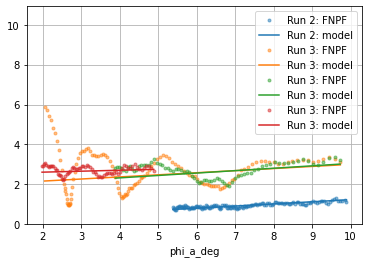

In [45]:
amplitudes_motions = examples.mdl.analyze_amplitudes(models=models_motions)

## Plotting:
fig,ax=plt.subplots()
for id,row in df_results.loc[~mask_visc].iterrows(): 
    df_amplitudes = amplitudes_motions[id].copy()
    df_amplitudes.sort_values(by='phi_a', inplace=True)
    df_amplitudes['phi_a_deg'] = np.rad2deg(df_amplitudes['phi_a'])
    plot_amplitudes(df_amplitudes=df_amplitudes, paper_name = row.paper_name, source='FNPF', ax=ax)
ax.set_ylim(y_lim_motions)

## Roll damping prediction with Hybrid method
Calculated the roll damping with Ikeda's method for zero speed and 15.5 knots. The damping was [compared](../../notebooks/04.3_KVLCC2_Ikedas_model_tests.ipynb#speeds) with corresponding values obtained from the model tests. The results showed good agreement between the model tests and predictions at speed. The damping predicted with Ikeda's method at zero knots was significantly higher than the corresponding model test. The predicted eddy damping was very large and is most likey overpredicted.  

Much effort was made to investigate the eddy damping prediction of the Ikeda's method implementation. It was found, by conducting a sensitivity analysis, that the predicted eddy damping was extremely sensitive to ship sections with almost rectangular shape, where the section area coefficient [sigma](../../notebooks/08.2_ikeda_eddy_sigma.ipynb) was close to one. According to Kawahara the mid section coefficient should not exceed 0.99, which otherwise seem to give a huge extrapolation error according to the [figure](../../notebooks/08.2_ikeda_eddy_sigma.ipynb) above. This was however the case for many of the sections of the KVLCC2, where the limiting value was instead used, to avoid unrealistic extrapolation errors.

It seems that mid section coefficient most often exceeds 0.99 based on statistics from MDL tests during the past 15 years: [plot](../../notebooks/09.1_sigma_statistics.ipynb)

Eddy damping gets smaller as the speed increases and has almost vanished for the 15.5 knots which can be seen in [plot](../../notebooks/06.1_KVLCC2_motions.ipynb#speed). So the difficulties with eddy damping prediction for high mid section coefficients is mostly a low speed problem; And in the presens of bilge keels, the bilge keel damping would be the dominating contribution to the roll damping at low speed as can be seen in <cite data-cite="7505983/FJHQJJUH"></cite>. So this is mostly a problem at low speed for ships without bilge keels.

Attempts where made to use Ikeda's alternative eddy damping formula for barges. This one did not work the $B_E$ is far to large: [07.1_ikeda_barge](../../notebooks/07.1_ikeda_barge.ipynb)


FNPF gave stable results at zero speed, but very unstable results at speed, due to what was thought to be memory effects. Instead the Hybrid method was attempted, where viscous damping from Ikeda's method is present during the FNPF simulations.

Firstly when looking at predictions for KVLCC2 at 0 speed made with regular Ikeda's method, it was found that the eddy damping $B_E$ was too high compared with the regular implementation, compared to the model test results. Eventhough the rest of the components would also be overpredicted, the $B_E$ would still be too large. The eddy damping calculated with $C_r$ predicted with the descision tree gave much better agreement. 

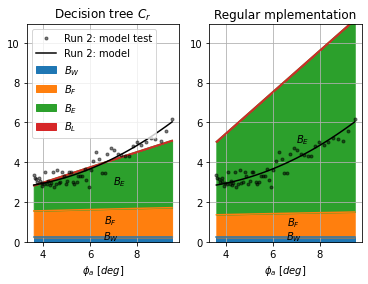

In [68]:
reports.examples.ikeda.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=y_lim_motions)

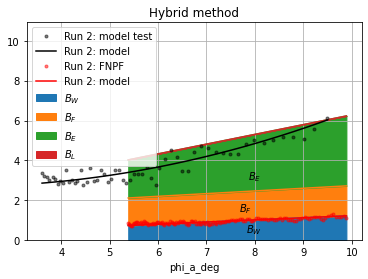

In [65]:
reports.examples.hybrid_0.show(amplitudes=amplitudes, amplitudes_motions=amplitudes_motions, 
                            models_mdl=models_mdl, ylim=y_lim_motions)

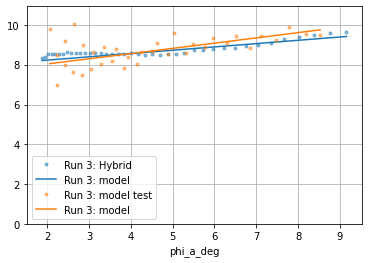

In [72]:
reports.examples.hybrid_speed.show_frequency(df_results=df_results, amplitudes=amplitudes, 
                                   amplitudes_motions=amplitudes_motions, 
                                   ylim=y_lim_motions)

The results using the Hybrid method for Run 3 at speed gives very similar results to the corresponding model tests.

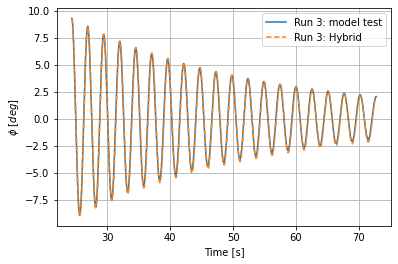

In [76]:
reports.examples.hybrid_speed.show_time(models_mdl=models_mdl, models_motions=models_motions)

# Conclusions

# References
<div class="cite2c-biblio"></div>